# 한국어 word2vec 작성

- skipgram, window size 2 의 simplified word2vec model 작성

In [ ]:
# Install konlpy
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

세션 재시작하세요.

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import numpy as np
import re

### Toy 말뭉치

In [3]:
corpus = ['왕은 매우 강한 남자이다',
          '여왕은 현명한 예쁜 여자이다',
          '소년은 젊은 남자이다',
          '소녀는 젊은 예쁜 여자이다',
          '왕자는 젊고 현명한 왕이 될 것이다',
          '공주는 젊고 예쁜 현명한 여왕이 될 것이다',
          '남자는 강하다',
          '여자는 예쁘다',
          '왕자는 왕이 될 소년이다',
          '공주는 왕비가 될 소녀이다']

In [4]:
cleaned_corpus = []
for text in corpus:
    print(text)
    text = re.sub(r'[^a가-힣]', '', text)  #한글
    cleaned_corpus.append(text.lower())

왕은 매우 강한 남자이다
여왕은 현명한 예쁜 여자이다
소년은 젊은 남자이다
소녀는 젊은 예쁜 여자이다
왕자는 젊고 현명한 왕이 될 것이다
공주는 젊고 예쁜 현명한 여왕이 될 것이다
남자는 강하다
여자는 예쁘다
왕자는 왕이 될 소년이다
공주는 왕비가 될 소녀이다


### stopword 제거

In [5]:
from konlpy.tag import Okt
okt = Okt()
okt.morphs

<bound method Okt.morphs of <konlpy.tag._okt.Okt object at 0x7de13c11fcd0>>

In [6]:
stop_words = ['은', '가', '이다', '는', '이', '될']

results = []

for text in corpus:
    tmp = []
    for word in okt.morphs(text):
        if word not in stop_words:
            tmp.append(word)
    results.append(' '.join(tmp))

In [7]:
cleaned_corpus = results
cleaned_corpus

['왕 매우 강한 남자',
 '여왕 현명한 예쁜 여자',
 '소년 젊은 남자',
 '소녀 젊은 예쁜 여자',
 '왕자 젊고 현명한 왕 것',
 '공주 젊고 예쁜 현명한 여왕 것',
 '남자 강하다',
 '여자 예쁘다',
 '왕자 왕 소년',
 '공주 왕비 소녀']

### vocaburary 모음 작성

In [8]:
words = []

for sentence in cleaned_corpus:
    for word in sentence.split(' '):
        words.append(word)

words = list(set(words))
words

['젊고',
 '소년',
 '소녀',
 '예쁘다',
 '남자',
 '현명한',
 '젊은',
 '여자',
 '매우',
 '왕',
 '예쁜',
 '것',
 '공주',
 '강하다',
 '여왕',
 '왕자',
 '왕비',
 '강한']

### word-to-index, index-to-word 작성

- word 를 index 로 변환  

- sentence 를 word index 로 변환  

- window size 에 따라 train data 생성

In [9]:
word2index = dict((w, i) for i, w in enumerate(words))
index2word = dict((i, w) for i, w in enumerate(words))

In [10]:
word2index

{'젊고': 0,
 '소년': 1,
 '소녀': 2,
 '예쁘다': 3,
 '남자': 4,
 '현명한': 5,
 '젊은': 6,
 '여자': 7,
 '매우': 8,
 '왕': 9,
 '예쁜': 10,
 '것': 11,
 '공주': 12,
 '강하다': 13,
 '여왕': 14,
 '왕자': 15,
 '왕비': 16,
 '강한': 17}

### skip-gram 으로 training data 생성

In [11]:
sentences = []
for sentence in cleaned_corpus:
    sentences.append(sentence.split())
sentences

[['왕', '매우', '강한', '남자'],
 ['여왕', '현명한', '예쁜', '여자'],
 ['소년', '젊은', '남자'],
 ['소녀', '젊은', '예쁜', '여자'],
 ['왕자', '젊고', '현명한', '왕', '것'],
 ['공주', '젊고', '예쁜', '현명한', '여왕', '것'],
 ['남자', '강하다'],
 ['여자', '예쁘다'],
 ['왕자', '왕', '소년'],
 ['공주', '왕비', '소녀']]

In [12]:
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] :
            if neighbor != word:
                data.append([word, neighbor])

In [13]:
data[:10]

[['왕', '매우'],
 ['왕', '강한'],
 ['매우', '왕'],
 ['매우', '강한'],
 ['매우', '남자'],
 ['강한', '왕'],
 ['강한', '매우'],
 ['강한', '남자'],
 ['남자', '매우'],
 ['남자', '강한']]

In [14]:
import pandas as pd

df = pd.DataFrame(data, columns = ['input', 'label'])
df.head()

,input,label
0,왕,매우
1,왕,강한
2,매우,왕
3,매우,강한
4,매우,남자


### One hot encoding

In [15]:
from tensorflow.keras.utils import to_categorical

len(words)

18

### One hot encoding 된 train, label data

In [16]:
X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_categorical(word2index[x], len(words)))
    Y.append(to_categorical(word2index[x], len(words)))

In [17]:
print(X[:3])
print(Y[:3])

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)]
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)]


In [18]:
# convert them to numpy arrays
X_train = np.array(X)
Y_train = np.array(Y)

**시각화를 위해 hidden layer 의 unit 을 2 로 제한**

In [19]:
model = Sequential()
model.add(Dense(2, input_dim=len(words)))
model.add(Dense(len(words)))

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [20]:
model.fit(X_train, Y_train, epochs=500, batch_size=3)

Epoch 1/500
28/28 [==============================] - 1s 2ms/step - loss: 8.6043 - accuracy: 0.0000e+00
Epoch 2/500
28/28 [==============================] - 0s 2ms/step - loss: 8.3038 - accuracy: 0.0357
Epoch 3/500
28/28 [==============================] - 0s 2ms/step - loss: 9.4027 - accuracy: 0.0595
Epoch 4/500
28/28 [==============================] - 0s 2ms/step - loss: 8.8266 - accuracy: 0.0595 
Epoch 5/500
28/28 [==============================] - 0s 2ms/step - loss: 8.8266 - accuracy: 0.0595 
Epoch 6/500
28/28 [==============================] - 0s 3ms/step - loss: 8.8266 - accuracy: 0.0595
Epoch 7/500
28/28 [==============================] - 0s 2ms/step - loss: 8.8266 - accuracy: 0.0595
Epoch 8/500
28/28 [==============================] - 0s 3ms/step - loss: 8.8266 - accuracy: 0.0595
Epoch 9/500
28/28 [==============================] - 0s 2ms/step - loss: 8.8266 - accuracy: 0.0595
Epoch 10/500
28/28 [==============================] - 0s 2ms/step - loss: 8.8266 - accuracy: 0.0595
Epo

### 첫번째 Hidden Layer 추출 및 weight + bias 를 vector 로 합산

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 38        
                                                                 
 dense_1 (Dense)             (None, 18)                54        
                                                                 
Total params: 92 (368.00 Byte)
Trainable params: 92 (368.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
model.layers[0].get_weights()

[array([[-0.41871086, -0.543144  ],
        [ 0.00138753, -0.46068326],
        [ 0.27011922, -0.26410815],
        [ 0.4465863 ,  0.2264269 ],
        [-0.29233298, -0.06572312],
        [-0.04172575, -0.27380866],
        [-0.17269161, -0.18121499],
        [ 0.21609235,  0.2727946 ],
        [-0.43461627, -0.02151918],
        [-0.29345304,  0.17721629],
        [-0.49799988, -0.551796  ],
        [-0.05005118,  0.07679216],
        [-0.148121  , -0.53803307],
        [ 0.06383353, -0.5107018 ],
        [ 0.49617374, -0.00795734],
        [-0.47770536,  0.00904149],
        [ 0.2027029 ,  0.4078645 ],
        [ 0.29777387, -0.1658304 ]], dtype=float32),
 array([-0.0121728 , -0.02490589], dtype=float32)]

In [23]:
vectors= model.layers[0].get_weights()[0] + model.layers[0].get_weights()[1]
vectors[:5]

array([[-0.43088365, -0.5680499 ],
       [-0.01078528, -0.48558915],
       [ 0.25794643, -0.28901404],
       [ 0.43441352,  0.20152101],
       [-0.30450577, -0.09062901]], dtype=float32)

In [24]:
words

['젊고',
 '소년',
 '소녀',
 '예쁘다',
 '남자',
 '현명한',
 '젊은',
 '여자',
 '매우',
 '왕',
 '예쁜',
 '것',
 '공주',
 '강하다',
 '여왕',
 '왕자',
 '왕비',
 '강한']

In [25]:
w2v = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v['word'] = words
w2v

,x1,x2,word
0,-0.430884,-0.568050,젊고
1,-0.010785,-0.485589,소년
2,0.257946,-0.289014,소녀
3,0.434414,0.201521,예쁘다
4,-0.304506,-0.090629,남자
5,-0.053899,-0.298715,현명한
6,-0.184864,-0.206121,젊은
7,0.203920,0.247889,여자
8,-0.446789,-0.046425,매우
9,-0.305626,0.152310,왕


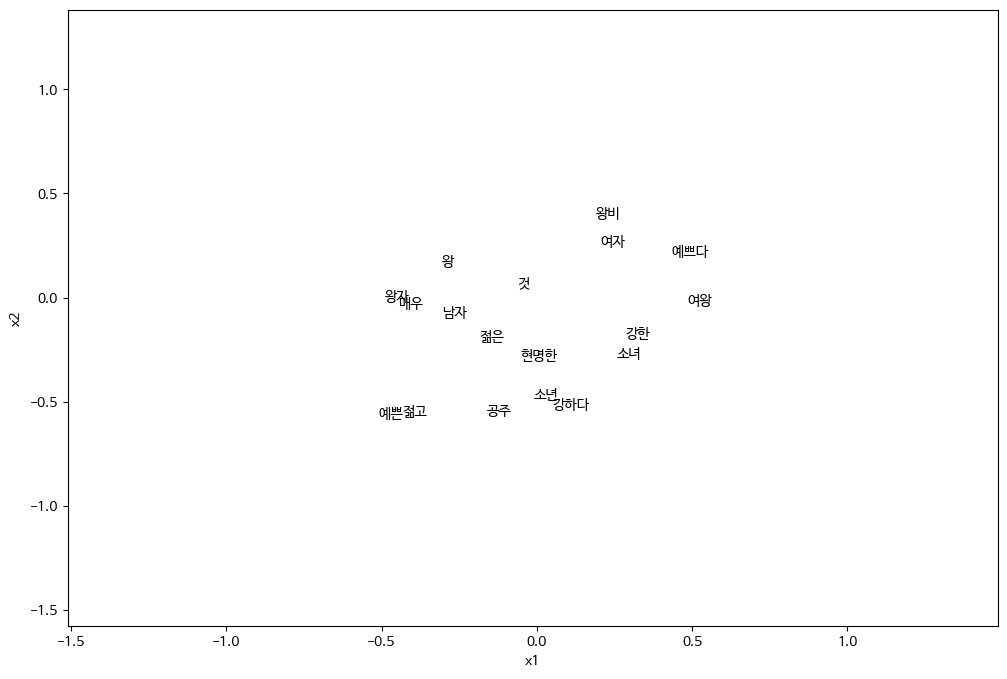

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False               #한글사용시 마이너스 사인 깨짐 방지


fig, ax = plt.subplots(figsize=(12,8))

for word, x1, x2 in zip(w2v['word'], w2v['x1'], w2v['x2']):
    ax.annotate(word, (x1, x2))

PADDING = 1.0
x_axis_min = np.min(vectors, axis=0)[0] - PADDING
y_axis_min = np.min(vectors, axis=0)[1] - PADDING
x_axis_max = np.max(vectors, axis=0)[0] + PADDING
y_axis_max = np.max(vectors, axis=0)[1] + PADDING

plt.xlim(x_axis_min, x_axis_max)
plt.ylim(y_axis_min, y_axis_max)
plt.xlabel('x1')
plt.ylabel('x2')

plt.show()